In [1]:
import collections
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
import tensorflow_text as tf_text

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

In [3]:
dataset_dir = '..\\data'
train_dir = f"{dataset_dir}\\tr"
batch_size = 32
seed = 42

In [4]:
def labeler(example, index):
    return example, tf.cast(index, tf.int64)

In [5]:
FILE_NAMES = ['negativesentences.txt', 'neutralsentences.txt', 'positivesentences.txt']
labeled_data_sets = []
# Give labels to the data, 0 for negatives, 1 for neutrals, 2 for positives.
for i, file_name in enumerate(FILE_NAMES):
    lines_dataset = tf.data.TextLineDataset(f"{train_dir}\\{file_name}")
    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
    labeled_data_sets.append(labeled_dataset)

In [6]:
BUFFER_SIZE = 50000
BATCH_SIZE = 32
VALIDATION_SIZE = 5000
VOCAB_SIZE = 15000

In [7]:
# concatenate all labeled datasets into one and shuffle
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
    all_labeled_data = all_labeled_data.concatenate(labeled_dataset)
all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)

In [8]:
print('Labels are 0 = negative, 1 = neutral, 2 = positive.\n')
for text, label in all_labeled_data.take(10):
    print("Sentence: ", text.numpy())
    print("Label:", label.numpy())

Labels are 0 = negative, 1 = neutral, 2 = positive.

Sentence:  b'Mink\xc3\xa4laiset ajatukset tekev\xc3\xa4t sinut katkeraksi?'
Label: 1
Sentence:  b'sopii tulla homo koittaa p\xc3\xa4\xc3\xa4set paluu postiin hein\xc3\xa4seiv\xc3\xa4s perseess\xc3\xa4'
Label: 0
Sentence:  b'Kohta ei se en\xc3\xa4\xc3\xa4 onnistu.'
Label: 1
Sentence:  b'Sek\xc3\xa4 danin kannattanee paukuttaa suihkussa pikkukakkoseen.'
Label: 1
Sentence:  b'Otsikkotekstin perusteella olet sit\xc3\xa4 mielt\xc3\xa4, ett\xc3\xa4 Raamatun Jeesuksen oli oltava Jumalan poika, koska h\xc3\xa4n omasi Raamatun kertomuksen mukaan ESP-kyvyn.'
Label: 1
Sentence:  b'-Onko rca-&gt;monoplugi piuhasi varmasti oikein kolvattu, n\xc3\xa4et ei n\xc3\xa4it\xc3\xa4 kaupasta saa'
Label: 1
Sentence:  b'Voi ristus mit\xc3\xa4 neuvoja anteeks vaan..'
Label: 0
Sentence:  b'Tuossa viestiss\xc3\xa4si ei ollut mit\xc3\xa4\xc3\xa4n viitett\xc3\xa4 erektioon tai miten voimaharjoittelu vaikuttaa testoarvoihin?'
Label: 1
Sentence:  b'Kas viestini po

In [9]:
tokenizer = tf_text.UnicodeScriptTokenizer()

In [10]:
def tokenize(text, unused_label):
    lower_case = tf_text.case_fold_utf8(text)
    return tokenizer.tokenize(lower_case)

tokenized_ds = all_labeled_data.map(tokenize)

Instructions for updating:
`tf.batch_gather` is deprecated, please use `tf.gather` with `batch_dims=-1` instead.


In [11]:
for text_batch in tokenized_ds.take(5):
    print("Tokens: ", text_batch.numpy())

Tokens:  [b'mink\xc3\xa4laiset' b'ajatukset' b'tekev\xc3\xa4t' b'sinut'
 b'katkeraksi' b'?']
Tokens:  [b'sopii' b'tulla' b'homo' b'koittaa' b'p\xc3\xa4\xc3\xa4set' b'paluu'
 b'postiin' b'hein\xc3\xa4seiv\xc3\xa4s' b'perseess\xc3\xa4']
Tokens:  [b'kohta' b'ei' b'se' b'en\xc3\xa4\xc3\xa4' b'onnistu' b'.']
Tokens:  [b'sek\xc3\xa4' b'danin' b'kannattanee' b'paukuttaa' b'suihkussa'
 b'pikkukakkoseen' b'.']
Tokens:  [b'otsikkotekstin' b'perusteella' b'olet' b'sit\xc3\xa4' b'mielt\xc3\xa4'
 b',' b'ett\xc3\xa4' b'raamatun' b'jeesuksen' b'oli' b'oltava' b'jumalan'
 b'poika' b',' b'koska' b'h\xc3\xa4n' b'omasi' b'raamatun' b'kertomuksen'
 b'mukaan' b'esp' b'-' b'kyvyn' b'.']


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_dataset(dataset):
    return dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
tokenized_ds = configure_dataset(tokenized_ds)

vocab_dict = collections.defaultdict(lambda: 0)
for toks in tokenized_ds.as_numpy_iterator():
    for tok in toks:
        vocab_dict[tok] += 1

vocab = sorted(vocab_dict.items(), key=lambda x: x[1], reverse=True)
vocab = [token for token, count in vocab]
vocab = vocab[:VOCAB_SIZE]
vocab_size = len(vocab)
print("Vocab size: ", vocab_size)
print("First five vocab entries:", vocab[:5])

Vocab size:  15000
First five vocab entries: [b'.', b',', b'ja', b'on', b'ei']


In [14]:
keys = vocab
values = range(2, len(vocab) + 2)  # reserve 0 for padding, 1 for OOV

init = tf.lookup.KeyValueTensorInitializer(
    keys, values, key_dtype=tf.string, value_dtype=tf.int64)

num_oov_buckets = 1
vocab_table = tf.lookup.StaticVocabularyTable(init, num_oov_buckets)

In [15]:
def preprocess_text(text, label):
    standardized = tf_text.case_fold_utf8(text)
    tokenized = tokenizer.tokenize(standardized)
    vectorized = vocab_table.lookup(tokenized)
    return vectorized, label

In [16]:
example_text, example_label = next(iter(all_labeled_data))
print("Sentence: ", example_text.numpy())
vectorized_text, example_label = preprocess_text(example_text, example_label)
print("Vectorized sentence: ", vectorized_text.numpy())

Sentence:  b'Mink\xc3\xa4laiset ajatukset tekev\xc3\xa4t sinut katkeraksi?'
Vectorized sentence:  [ 6418  3051   829   844 11745    10]


In [17]:
all_encoded_data = all_labeled_data.map(preprocess_text)

In [18]:
train_data = all_encoded_data.skip(VALIDATION_SIZE).shuffle(BUFFER_SIZE)
validation_data = all_encoded_data.take(VALIDATION_SIZE)

In [19]:
train_data = train_data.padded_batch(BATCH_SIZE)
validation_data = validation_data.padded_batch(BATCH_SIZE)

In [20]:
sample_text, sample_labels = next(iter(validation_data))
print("Text batch shape: ", sample_text.shape)
print("Label batch shape: ", sample_labels.shape)
print("First text example: ", sample_text[0])
print("First label example: ", sample_labels[0])

Text batch shape:  (32, 63)
Label batch shape:  (32,)
First text example:  tf.Tensor(
[ 6418  3051   829   844 11745    10     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0], shape=(63,), dtype=int64)
First label example:  tf.Tensor(1, shape=(), dtype=int64)


In [21]:
vocab_size += 2

In [22]:
train_data = configure_dataset(train_data)
validation_data = configure_dataset(validation_data)

In [23]:
def create_model(vocab_size, num_labels):
    model = tf.keras.Sequential([
        layers.Embedding(vocab_size, 64, embeddings_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), mask_zero=True),
        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(32)),
        layers.Dropout(0.5),
        layers.Dense(32, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_labels)
  ])
    return model

In [24]:
model = create_model(vocab_size=vocab_size, num_labels=3)
model.summary()
callback = callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
history = model.fit(train_data, validation_data=validation_data, callbacks=[callback], epochs=15)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          960128    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9

In [25]:
test_loss, test_acc = model.evaluate(validation_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

157/157 [==============================] - 6s 31ms/step - loss: 0.8921 - accuracy: 0.7514
Test Loss: 0.8920513391494751
Test Accuracy: 0.7513999938964844


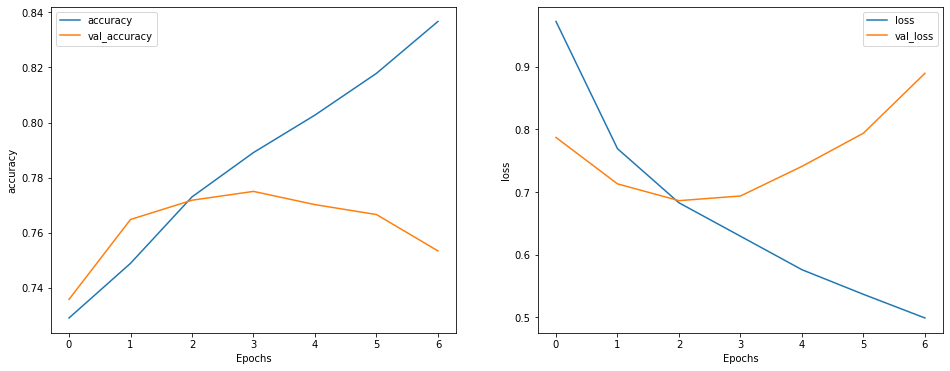

In [26]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [27]:
MAX_SEQUENCE_LENGTH = 250
preprocess_layer = TextVectorization(
    max_tokens=vocab_size,
    standardize=tf_text.case_fold_utf8,
    split=tokenizer.tokenize,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)
preprocess_layer.set_vocabulary(vocab)

In [28]:
export_model = tf.keras.Sequential(
    [preprocess_layer, model,
     layers.Activation('softmax')])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

In [29]:
# Create a test dataset of raw strings
test_ds = all_labeled_data.take(VALIDATION_SIZE).batch(BATCH_SIZE)
test_ds = configure_dataset(test_ds)
loss, accuracy = export_model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: {:2.2%}".format(accuracy))

157/157 [==============================] - 33s 74ms/step - loss: 0.8874 - accuracy: 0.7380
Loss:  0.8873558640480042
Accuracy: 73.80%


In [30]:
inputs = [
    "Saatanan paskiaiset eikö teillä Vimpeliläisillä ole muuta kuin paskaa jauhaa jostain teidän etujen puolustajajasta.",  # Label: 0
    "Kela hyväksyy vesimenot 20,60 euroon asti kuussa per asukas asuinpaikasta riippumatta. ",  # Label: 1
    "Sä oot mulle niin tärkeä ja rakas!",  # Label: 2
]
predicted_scores = export_model.predict(inputs)
predicted_labels = tf.argmax(predicted_scores, axis=1)
for input, label in zip(inputs, predicted_labels):
  print("Question: ", input)
  print("Predicted label: ", label.numpy())

Question:  Saatanan paskiaiset eikö teillä Vimpeliläisillä ole muuta kuin paskaa jauhaa jostain teidän etujen puolustajajasta.
Predicted label:  0
Question:  Kela hyväksyy vesimenot 20,60 euroon asti kuussa per asukas asuinpaikasta riippumatta. 
Predicted label:  1
Question:  Sä oot mulle niin tärkeä ja rakas!
Predicted label:  2
